This notebook contains a pipeline for preprocessing and classification flower images from the corresponding dataset.
The notebook consists of several parts:
1. data preprocessing: dividing the dataset into training, validation and test samples; application to the training set of data augmentation tools
2. experiments with different neural network architectures developed from scratch (successful and unsuccessful), selection of the most optimal architecture, in this block, we use approaches to combat with overfitting and improve model performance using data segmentation


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import zipfile
from shutil import copyfile
from time import time
import random as python_random
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data loader

In any deep learning or machine learning, it's needed to divide an original dataset into training, validation and/or test sets.

In our project we will use 3 sets despite the small number of instances in the initial dataset. To solve the problem of a small training set, we will apply data augmentation.

In [ ]:
copyfile('gdrive/My Drive/DL_project/flower_photos.zip', 'flower_photos.zip')
zip = zipfile.ZipFile('flower_photos.zip')
zip.extractall()
zip.close()

In [ ]:
base_path = '/content/flower_photos 2'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.3

### Training set

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


### Validation and test set

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_ds = val_dataset.take((val_batches) // 3)
val_ds = val_dataset.skip((val_batches) // 3)

In [ ]:
print("Number of batches in train dataset:", len(train_ds))
print("Number of batches in validation dataset:", len(val_ds))
print("Number of batches in test dataset:", len(test_ds))


Number of batches in train dataset: 81
Number of batches in validation dataset: 24
Number of batches in test dataset: 11


### Visualization of the train set

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


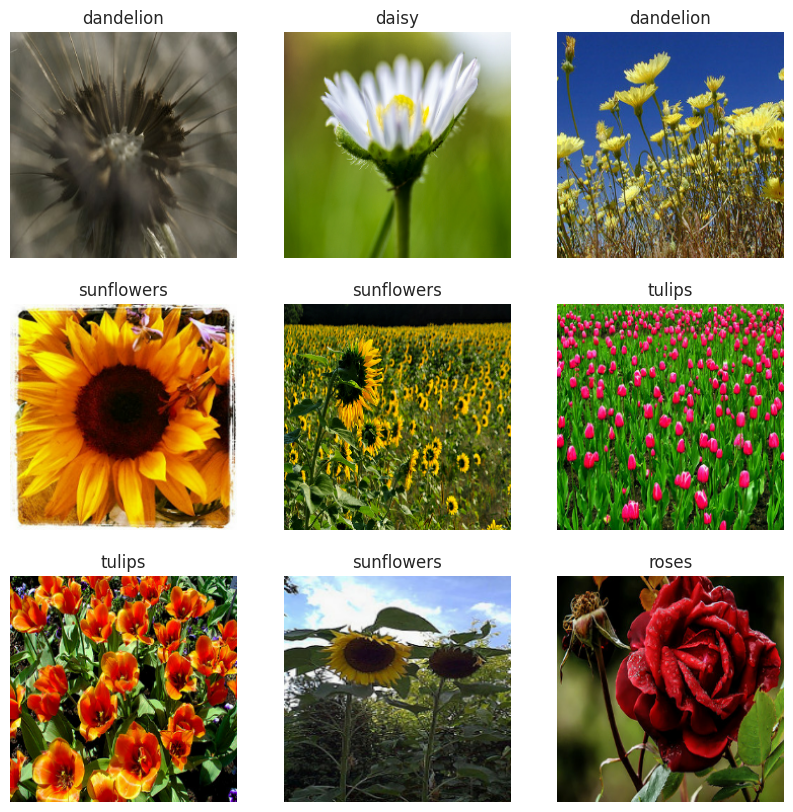

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = np.argmax(labels[i])  # convert one-hot label to class index
    plt.title(class_names[class_index])
    plt.axis("off")


### Checking classes for balance

In the classification problem, it is important that the dataset is balanced, that is, the number of instances in each class is the same, for further correct modeling.

This is important because we want to avoid the model learns only one class that dominates in the data and assigning this class label to all other instances in dataset

In [ ]:
def count_distribution(train_ds, val_ds, test_ds):

  train_class_counts = [0] * len(class_names)
  val_class_counts = [0] * len(class_names)
  test_class_counts = [0] * len(class_names)

  for images, labels in train_ds:
      batch_size = images.shape[0]
      for i in range(batch_size):
          train_class_index = tf.argmax(labels[i]).numpy()
          train_class_counts[train_class_index] += 1
  for images, labels in val_ds:
      batch_size = images.shape[0]
      for i in range(batch_size):
          val_class_index = tf.argmax(labels[i]).numpy()
          val_class_counts[val_class_index] += 1
  for images, labels in test_ds:
      batch_size = images.shape[0]
      for i in range(batch_size):
          test_class_index = tf.argmax(labels[i]).numpy()
          test_class_counts[test_class_index] += 1

  return train_class_counts, val_class_counts, test_class_counts



In [ ]:
train_class_counts, val_class_counts, test_class_counts = count_distribution(train_ds, val_ds, test_ds)

In [ ]:
def plot_distribution(class_counts):

  sns.barplot(x=class_names, y=class_counts, palette = 'deep')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.title('Image Distribution')

  # Add counts above each bar
  for i, count in enumerate(class_counts):
      plt.text(i, count, str(count), ha='center', va='bottom')

  plt.show()


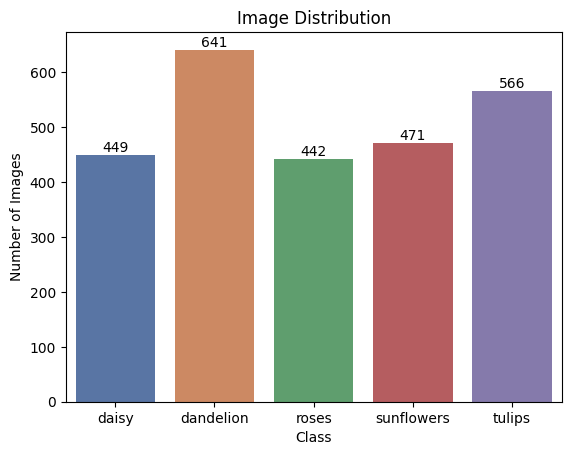

In [ ]:
plot_distribution(train_class_counts)

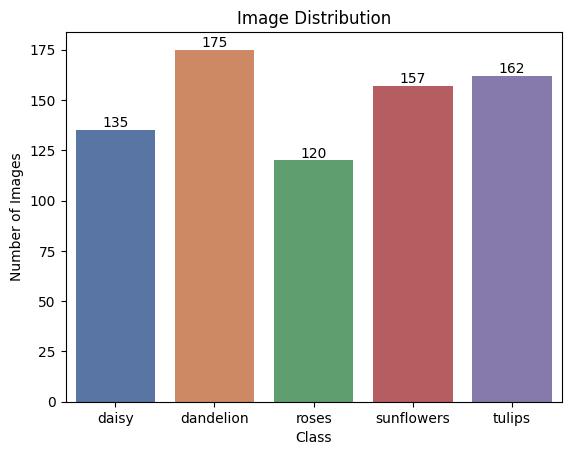

In [ ]:
plot_distribution(val_class_counts)

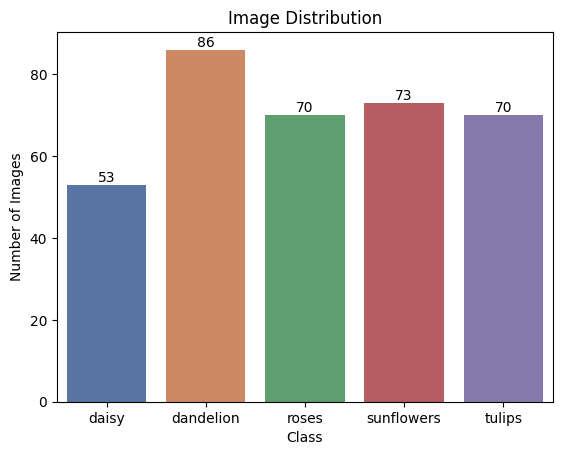

In [ ]:
plot_distribution(test_class_counts)

We see that in general the dataset is well balanced, there is a dominant class 'dandelion', but the difference between the number of images in other classes is not significant in our opinion, so we will continue to work with this dataset without changes

### Apply data augmentation technique

For applying data augmentation we choose zooming, random rotation and horizontal flip.

First we visualize chosen modification to the data

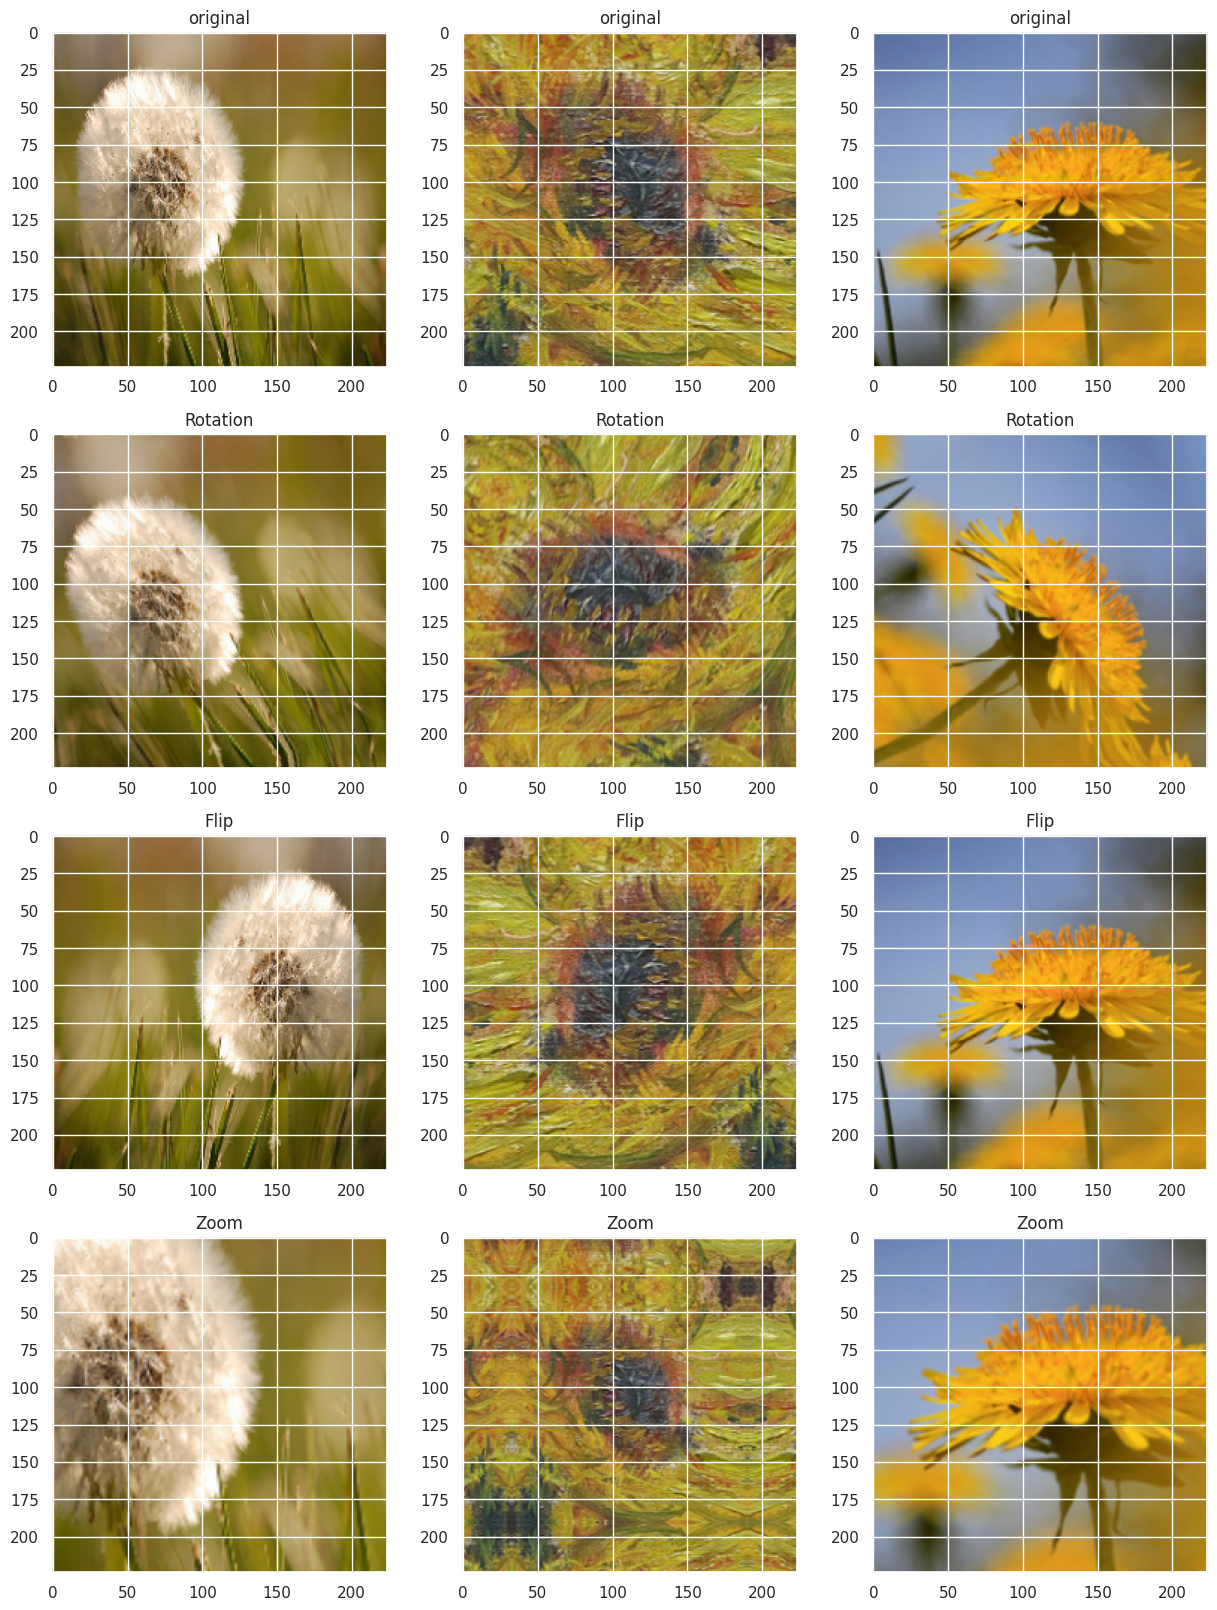

In [ ]:
zoom = tf.keras.layers.RandomZoom(0.5)
rotation = tf.keras.layers.RandomRotation(0.4)
flip = tf.keras.layers.RandomFlip('horizontal')

fig, ax = plt.subplots(4, 3, figsize=(15,20))

for images, labels in train_ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")

        ax[1][i].imshow(rotation(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("Rotation")

        ax[2][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("Flip")

        ax[3][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("Zoom")
plt.show()

Preparing set of layers for the data augmentation for the further usage in models

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomZoom(0.5),
        keras.layers.RandomRotation(0.4),
        keras.layers.RandomFlip('horizontal')
    ]
)

### Function for ploting model performance

In [ ]:
def plot_history(history):

    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize': (10, 6)})

    plt.subplot(1, 2, 1)
    loss_plot = sns.lineplot(data=history['loss'], color = 'blue', label= 'Train Loss', lw=1)
    val_loss_plot = sns.lineplot(data=history['val_loss'], color = 'red', label= 'Valid Loss', lw=1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    acc_plot = sns.lineplot(data=history['accuracy'], color = 'blue', label= 'Train Accuracy', lw=1)
    val_acc_plot = sns.lineplot(data=history['val_accuracy'],  color = 'red', label= 'Valid Accuracy', lw=1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.suptitle('Model Performance', fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_predicted(model, test_ds):
  for images, labels in test_ds.take(1):
      yhat = model.predict(images, verbose=0)
      y_pred = yhat.argmax(axis=1)

      batch_size = images.shape[0]
      num_rows = math.ceil(batch_size / 4)
      num_cols = 4

      plt.figure(figsize=(12, 12))

      for i in range(batch_size):
          plt.subplot(num_rows, num_cols, i + 1)
          plt.grid(False)
          plt.imshow(images[i].numpy().astype("uint8"))
          class_index = np.argmax(labels[i])  # convert one-hot label to class index
          plt.title('Real class: {} \n Predicted: {}'.format(class_names[class_index], class_names[y_pred[i]]))
          plt.axis("off")

      plt.tight_layout()
      plt.show()


# Defining a model from scratch

In [ ]:
num_classes = 5

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Model 0

This is model with 3 convolution layers with batch normalization and activation function 'relu', 2 dense layers and kernel regularizer

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)


outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        18496 

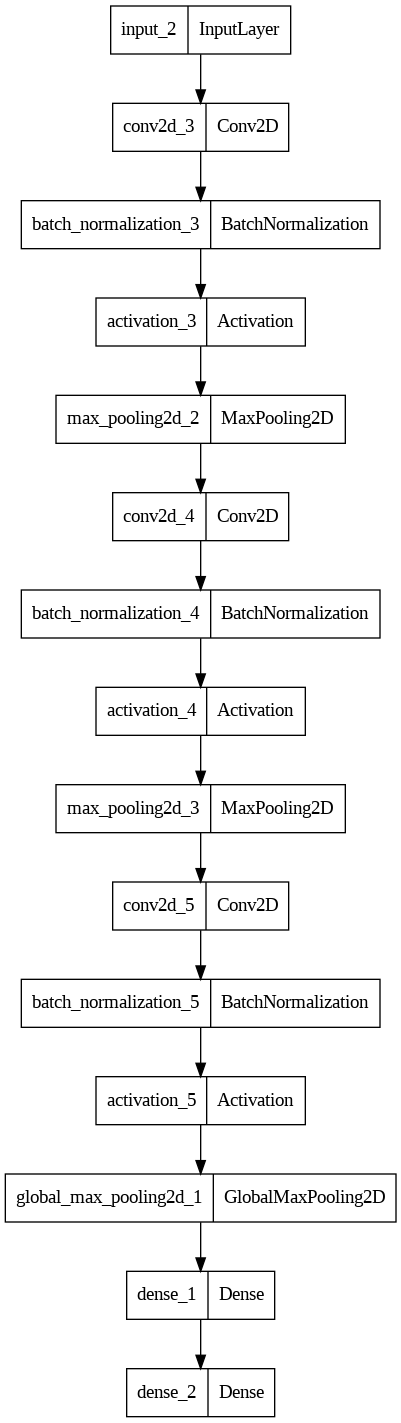

In [ ]:
keras.utils.plot_model(net, to_file='model.png')

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
%%time
history = net.fit(train_ds,
                  epochs=40,
                  validation_data=val_ds,
                  callbacks=[callback])

Epoch 1/40
81/81 [==============================] - 15s 115ms/step - loss: 1.2471 - accuracy: 0.5952 - val_loss: 1.4631 - val_accuracy: 0.5060
Epoch 2/40
81/81 [==============================] - 10s 113ms/step - loss: 0.9824 - accuracy: 0.7077 - val_loss: 1.1577 - val_accuracy: 0.6061
Epoch 3/40
81/81 [==============================] - 8s 97ms/step - loss: 0.8485 - accuracy: 0.7497 - val_loss: 1.0089 - val_accuracy: 0.6756
Epoch 4/40
81/81 [==============================] - 9s 99ms/step - loss: 0.7353 - accuracy: 0.8038 - val_loss: 0.9130 - val_accuracy: 0.7143
Epoch 5/40
81/81 [==============================] - 10s 117ms/step - loss: 0.6712 - accuracy: 0.8322 - val_loss: 0.9389 - val_accuracy: 0.7290
Epoch 6/40
81/81 [==============================] - 8s 90ms/step - loss: 0.6209 - accuracy: 0.8513 - val_loss: 0.8817 - val_accuracy: 0.7517
Epoch 7/40
81/81 [==============================] - 8s 98ms/step - loss: 0.5400 - accuracy: 0.8875 - val_loss: 1.3024 - val_accuracy: 0.6462
Epoch 8

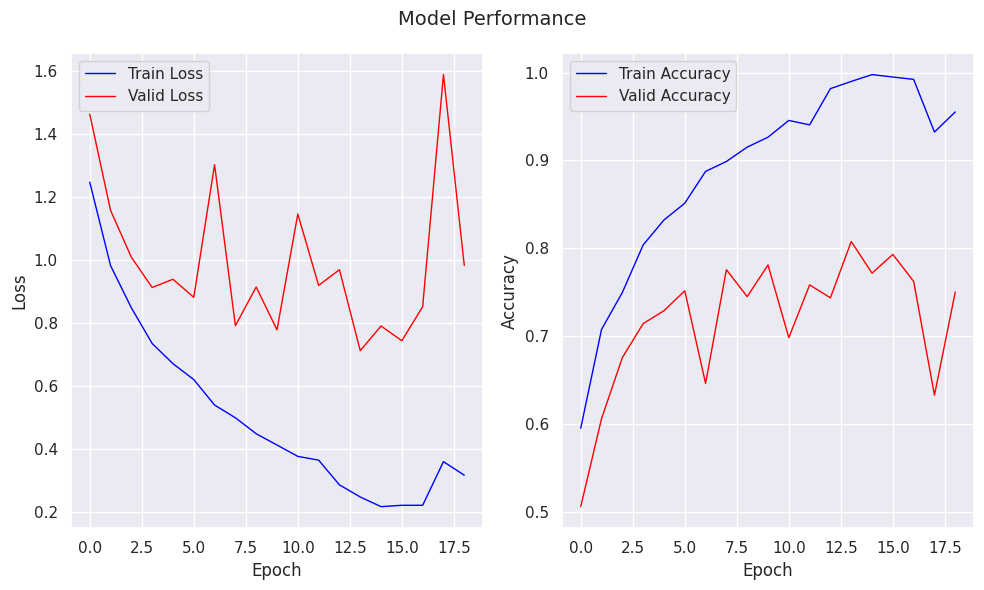

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/Model0Conv')
np.save('/content/gdrive/MyDrive/Models_DL_project/Model0Conv_history.npy', history.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/Model0Conv_history.npy'
model0Conv_history = np.load(path_history, allow_pickle=True).item()

# upload model
model0Conv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/Model0Conv")


In [ ]:
# test accuracy
loss, acc = model0Conv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 9s 789ms/step - loss: 0.9341 - accuracy: 0.7727
Test loss: 0.9341362118721008
Test Accuracy 0.7727272510528564


This model has signs of overtraining the model, as the gap between the accuracy on the training sample and the validation sample is quite large.
Accuracy on the test set is 77%.

Therefore in next model we going to use the same architecture but with addintion layers of Dropout for oreventing overfitting

We can explore specific images from test set with their real and predicted labels

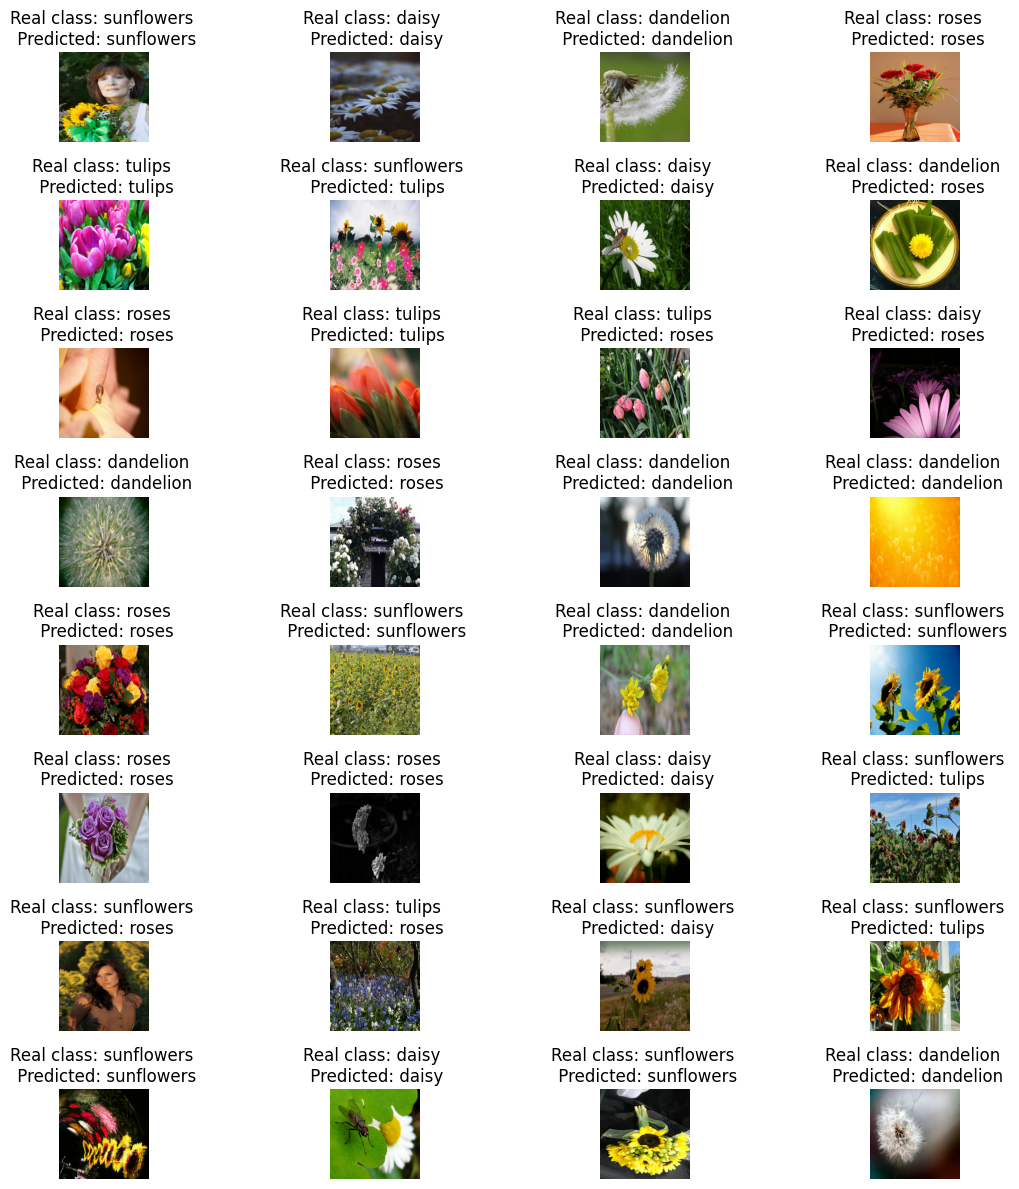

In [ ]:
plot_predicted(model0Conv, test_ds)

### Model 1

The same model with 3 convolution layers with batch normalization and activation function 'relu', 2 dense layers and kernel regularizer, but with Dropout after all convolution layers (during developing process we tried to add also Dropout between convolution layes, but accuracy was lower)



In [ ]:
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dropout(0,4)(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)


outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)        1849

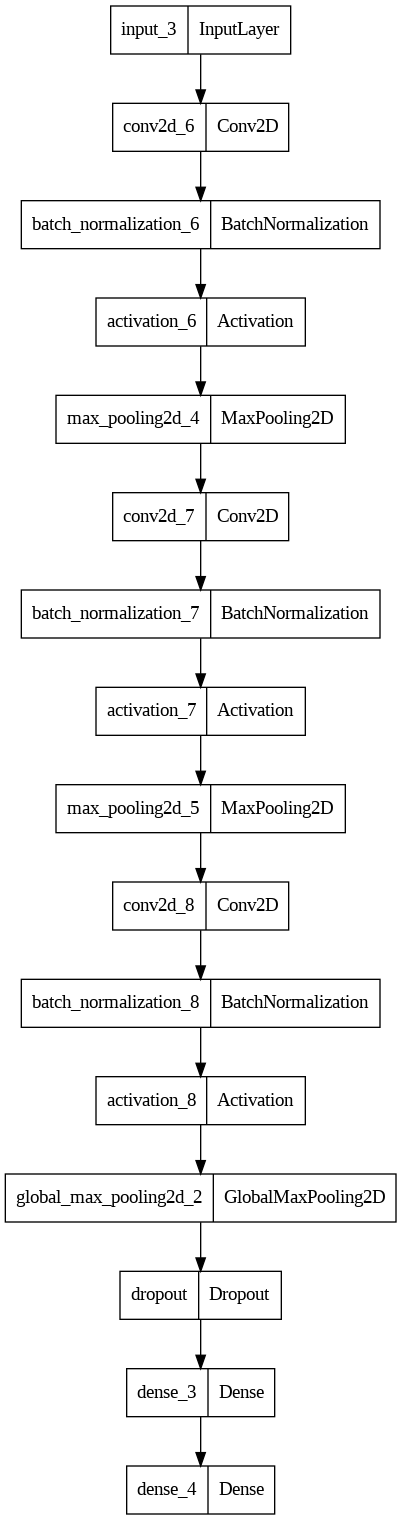

In [ ]:
keras.utils.plot_model(net, to_file='model.png')

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history = net.fit(train_ds,
          epochs=40,
          validation_data=val_ds,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/40
81/81 [==============================] - 12s 94ms/step - loss: 1.3216 - accuracy: 0.5808 - val_loss: 1.9410 - val_accuracy: 0.4005
Epoch 2/40
81/81 [==============================] - 10s 115ms/step - loss: 0.9898 - accuracy: 0.6948 - val_loss: 1.0200 - val_accuracy: 0.6729
Epoch 3/40
81/81 [==============================] - 11s 131ms/step - loss: 0.8510 - accuracy: 0.7528 - val_loss: 0.8847 - val_accuracy: 0.7383
Epoch 4/40
81/81 [==============================] - 12s 139ms/step - loss: 0.7875 - accuracy: 0.7742 - val_loss: 0.8586 - val_accuracy: 0.7650
Epoch 5/40
81/81 [==============================] - 11s 136ms/step - loss: 0.6875 - accuracy: 0.8346 - val_loss: 0.8393 - val_accuracy: 0.7543
Epoch 6/40
81/81 [==============================] - 13s 146ms/step - loss: 0.6306 - accuracy: 0.8400 - val_loss: 1.0204 - val_accuracy: 0.6822
Epoch 7/40
81/81 [==============================] - 12s 140ms/step - loss: 0.5857 - accuracy: 0.8700 - val_loss: 1.1354 - val_accuracy: 0.6876


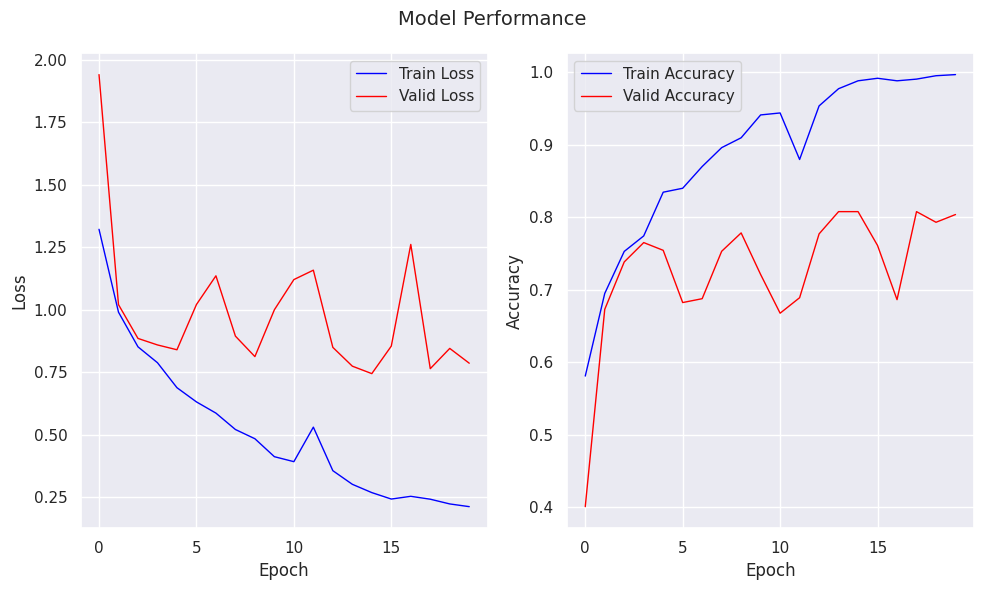

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/Model1Conv')
np.save('/content/gdrive/MyDrive/Models_DL_project/Model1Conv_history.npy', history.history)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/Model1Conv_history.npy'
model1Conv_history = np.load(path_history, allow_pickle=True).item()

# upload model
model1Conv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/Model1Conv")


In [ ]:
# test accuracy
loss, acc = model1Conv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 13s 1s/step - loss: 0.7093 - accuracy: 0.8210
Test loss: 0.7093178033828735
Test Accuracy 0.8210227489471436


The gap between train and validation accuracy become lower, we got higher accuracy score on test set that is 82%, but still we observe overfitting

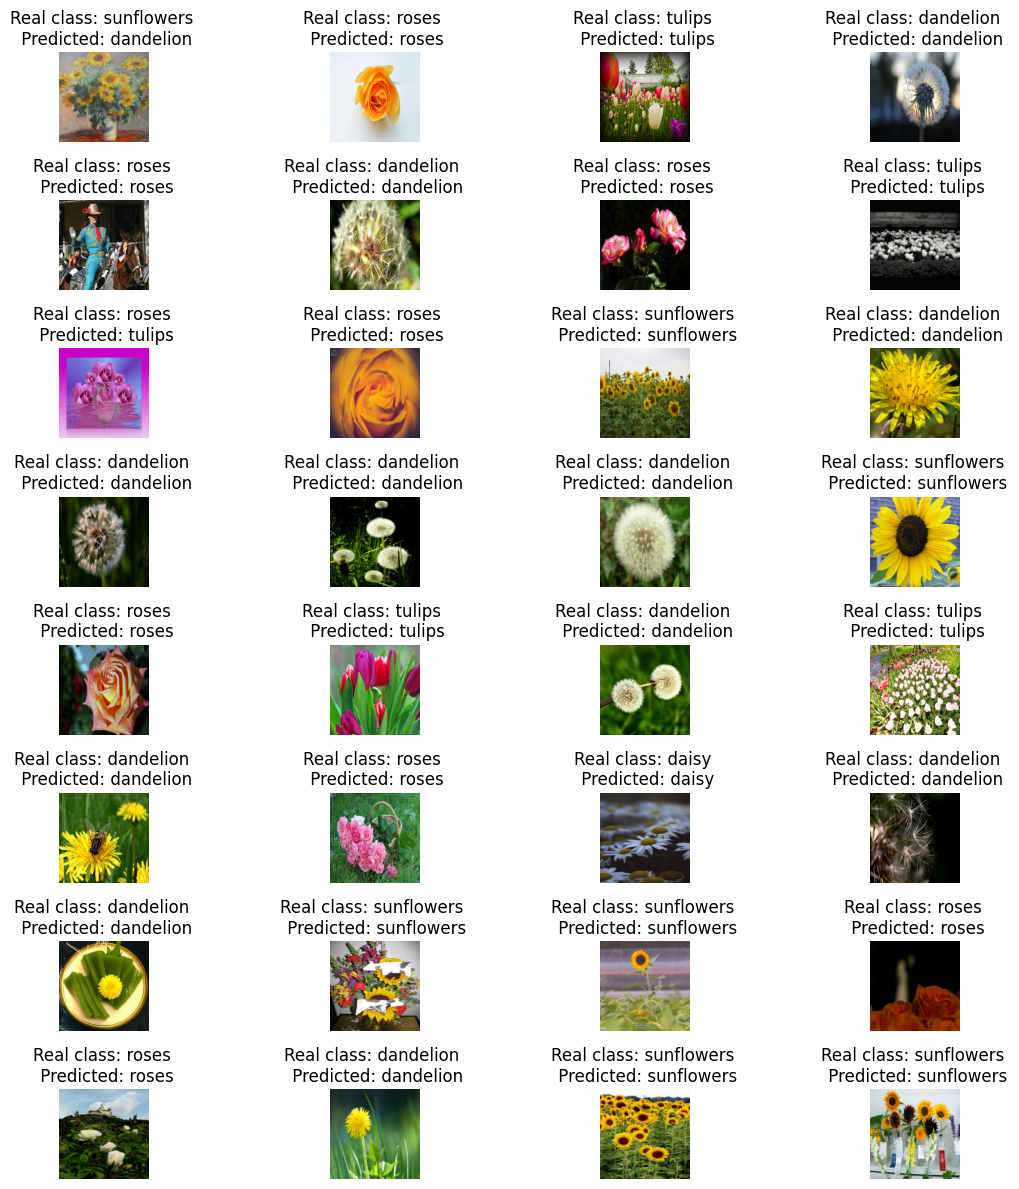

In [ ]:
plot_predicted(model1Conv, test_ds)

### Model 0 + augmentation

Finaly we apply data augmentation to the same nn architecture

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs
x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)


outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                       

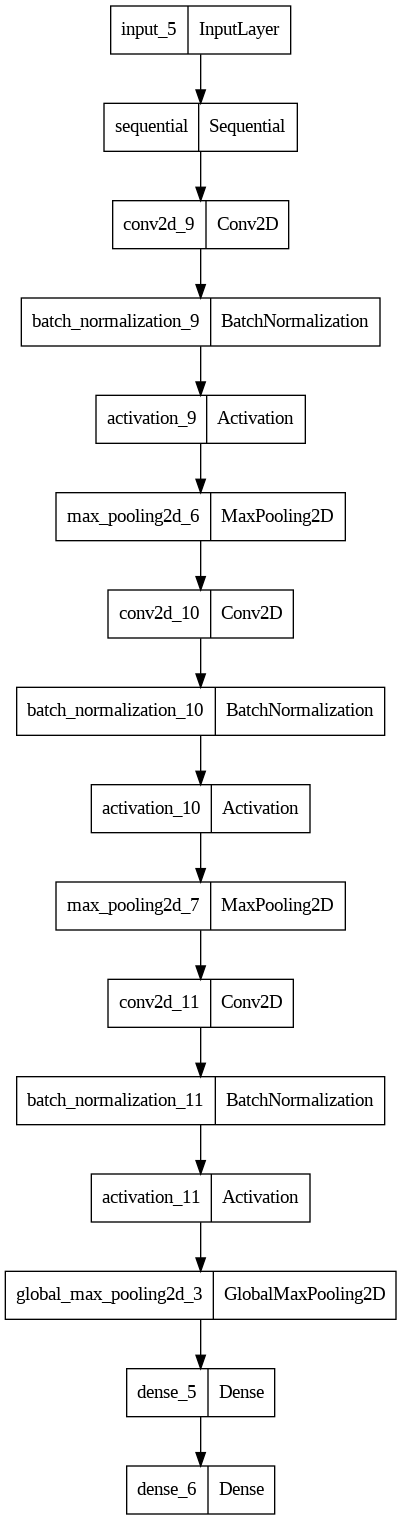

In [ ]:
keras.utils.plot_model(net, to_file='model.png')

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
%%time
history = net.fit(train_ds,
          epochs=50,
          validation_data=val_ds,
          callbacks=[callback]);

Epoch 1/50
81/81 [==============================] - 12s 94ms/step - loss: 1.4379 - accuracy: 0.5411 - val_loss: 2.0997 - val_accuracy: 0.3511
Epoch 2/50
81/81 [==============================] - 10s 111ms/step - loss: 1.1247 - accuracy: 0.6536 - val_loss: 1.2185 - val_accuracy: 0.5701
Epoch 3/50
81/81 [==============================] - 10s 113ms/step - loss: 1.0644 - accuracy: 0.6582 - val_loss: 1.2139 - val_accuracy: 0.5834
Epoch 4/50
81/81 [==============================] - 8s 93ms/step - loss: 1.0186 - accuracy: 0.6800 - val_loss: 1.1294 - val_accuracy: 0.6195
Epoch 5/50
81/81 [==============================] - 10s 115ms/step - loss: 0.9655 - accuracy: 0.7014 - val_loss: 0.9922 - val_accuracy: 0.6716
Epoch 6/50
81/81 [==============================] - 9s 112ms/step - loss: 0.9462 - accuracy: 0.7213 - val_loss: 1.0544 - val_accuracy: 0.6515
Epoch 7/50
81/81 [==============================] - 8s 92ms/step - loss: 0.9411 - accuracy: 0.7166 - val_loss: 0.9677 - val_accuracy: 0.7036
Epoch

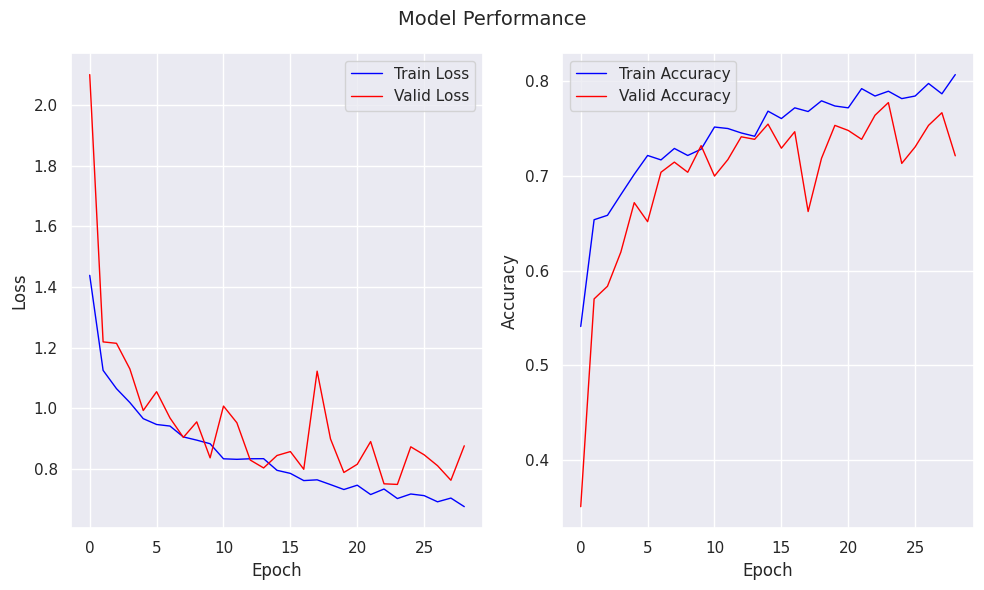

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/Model1AugmConv')
np.save('/content/gdrive/MyDrive/Models_DL_project/Model1AugmConv_history.npy', history.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/Model1AugmConv_history.npy'
model1AugmConv_history = np.load(path_history, allow_pickle=True).item()

# upload model
model1AugmConv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/Model1AugmConv")


In [ ]:
# test accuracy
loss, acc = model1AugmConv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 10s 778ms/step - loss: 0.9289 - accuracy: 0.7301
Test loss: 0.9289382696151733
Test Accuracy 0.7301136255264282


As we see data augmentation works better for this kind of model and data and we overcome problem of overfitting and still save 73% of accuracy in th test set (regardint to the accuracy of the model without data augmentation, which is 77%)

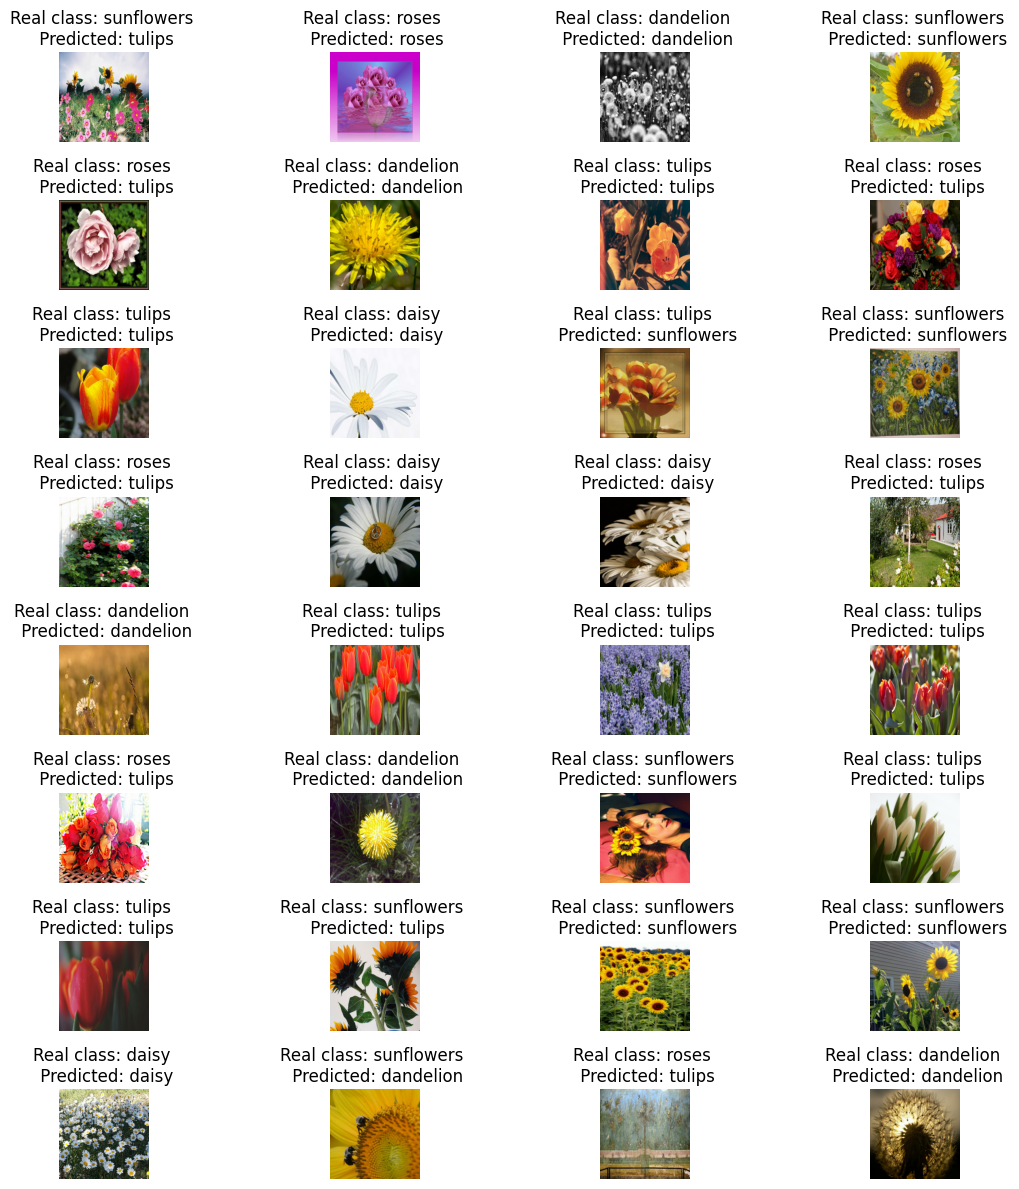

In [ ]:
plot_predicted(model1AugmConv, test_ds)

### Model 2

This model with another architecture compering to previous ones. It has 3 convolution layers, but with different kernel size and 3 dense layers

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs
x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

x = keras.layers.Conv2D(64, 5, strides = 2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(64, 5, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(5, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                       

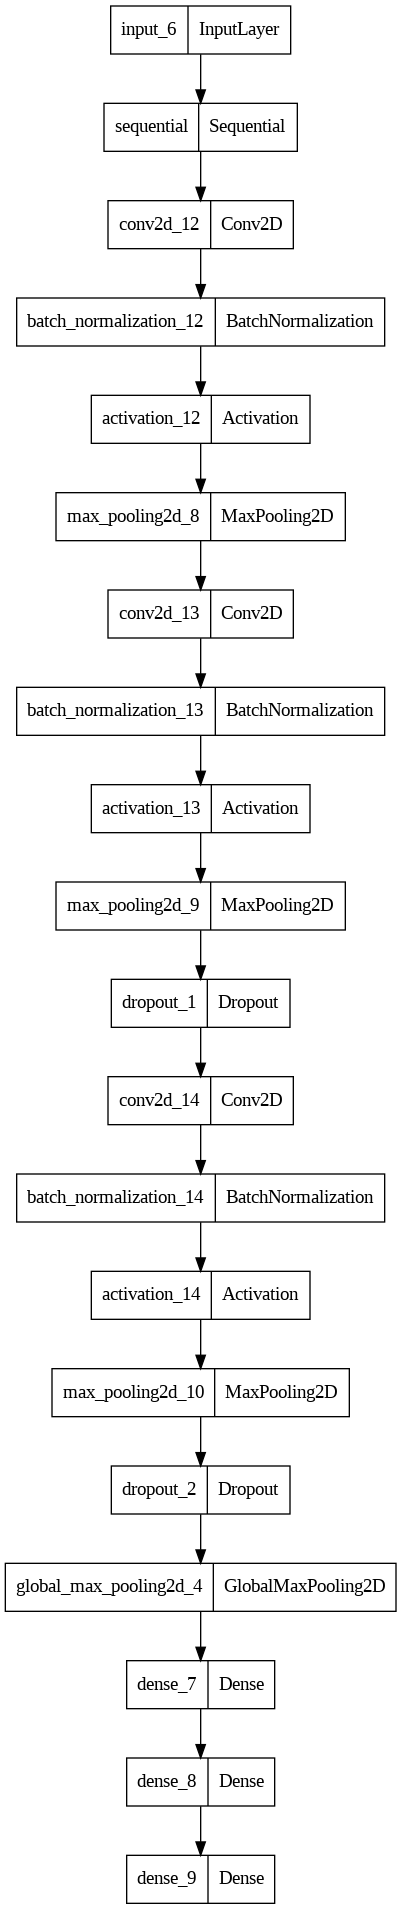

In [ ]:
keras.utils.plot_model(net, to_file='model.png')

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
%%time
history = net.fit(train_ds,
          epochs=40,
          validation_data=val_ds,
          callbacks=[callback]);

Epoch 1/40
81/81 [==============================] - 15s 115ms/step - loss: 1.3656 - accuracy: 0.5376 - val_loss: 1.5533 - val_accuracy: 0.4806
Epoch 2/40
81/81 [==============================] - 11s 125ms/step - loss: 1.1983 - accuracy: 0.5913 - val_loss: 1.2763 - val_accuracy: 0.5274
Epoch 3/40
81/81 [==============================] - 12s 145ms/step - loss: 1.1155 - accuracy: 0.6333 - val_loss: 1.2804 - val_accuracy: 0.5487
Epoch 4/40
81/81 [==============================] - 10s 122ms/step - loss: 1.0616 - accuracy: 0.6477 - val_loss: 1.0650 - val_accuracy: 0.6275
Epoch 5/40
81/81 [==============================] - 10s 120ms/step - loss: 1.0448 - accuracy: 0.6633 - val_loss: 1.0871 - val_accuracy: 0.6475
Epoch 6/40
81/81 [==============================] - 9s 108ms/step - loss: 1.0209 - accuracy: 0.6668 - val_loss: 1.0160 - val_accuracy: 0.6756
Epoch 7/40
81/81 [==============================] - 10s 122ms/step - loss: 0.9761 - accuracy: 0.6898 - val_loss: 0.9947 - val_accuracy: 0.6876


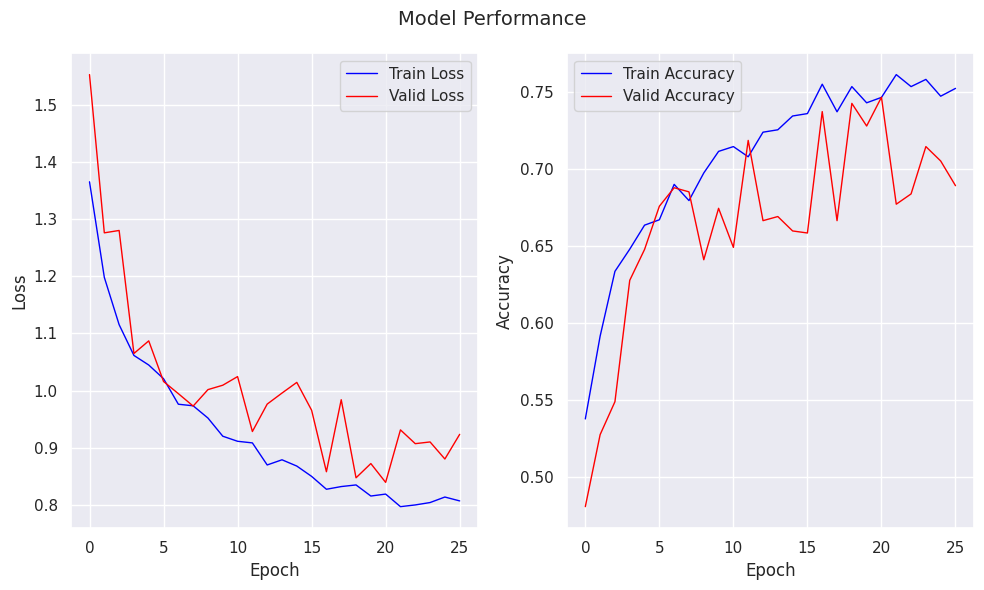

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/Model2Augm4Conv')
np.save('/content/gdrive/MyDrive/Models_DL_project/Model2Augm4Conv_history.npy', history.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/Model2Augm4Conv_history.npy'
model2Augm4Conv_history = np.load(path_history, allow_pickle=True).item()

# upload model
model2Augm4Conv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/Model2Augm4Conv")


In [ ]:
# test accuracy
loss, acc = model2Augm4Conv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 14s 1s/step - loss: 0.9684 - accuracy: 0.6705
Test loss: 0.9683521389961243
Test Accuracy 0.6704545617103577


Various experiments with this architecture (changing the kernel size and different strides sizes) failed to improve its performance.

Accuracy on the test sample is 67%

In [ ]:
plot_predicted(model2Augm4Conv, test_ds)

### Model 3

This model has more complex architecture then previous ones that can help us achieve better classififcation model. It has 6 convolution layers and also output block with max pooling each two convolution layers to save features that catched on start of the network

In [ ]:
inputs = keras.Input((224,224,3))
x = inputs
x = data_augmentation(x)

x = keras.layers.Conv2D(64, 7, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

block_1_output = keras.layers.MaxPooling2D(3, strides=1, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.MaxPooling2D(3, strides=1, padding="same")(block_2_output)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(64, 3, activation="relu")(block_3_output)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  9472        ['sequential[2][0]']             
                                )                                                                 
                                                                                            

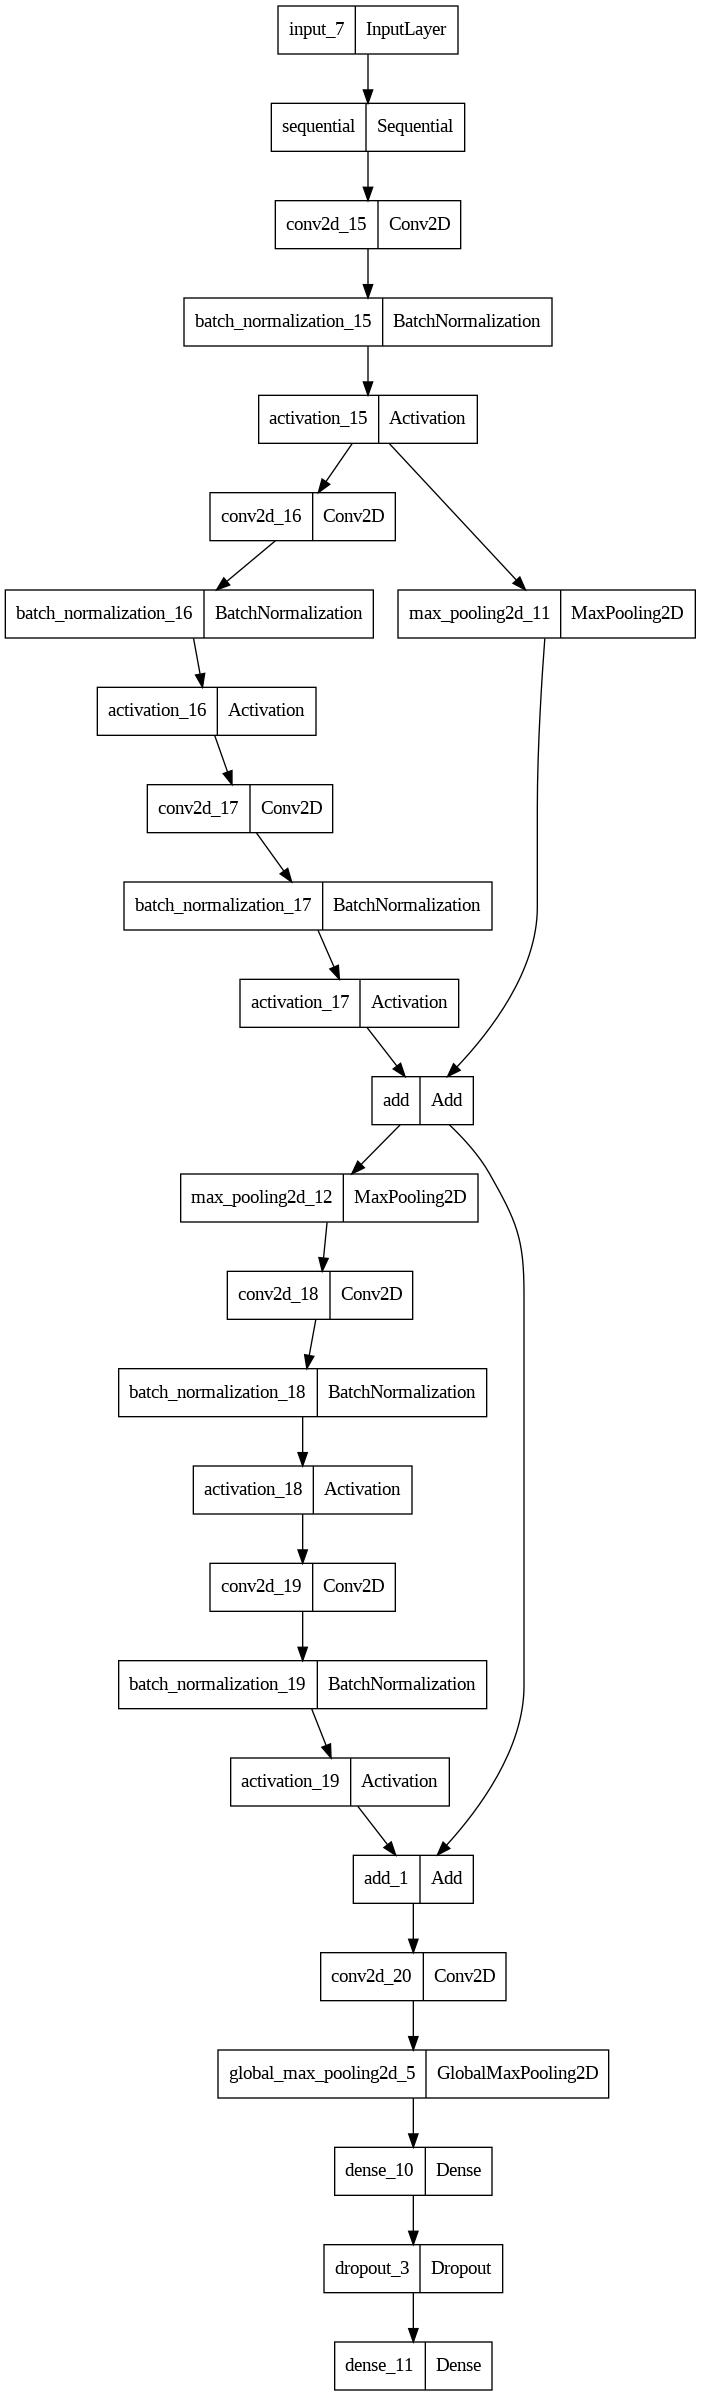

In [ ]:
keras.utils.plot_model(net, to_file='model.png')

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
%%time
history = net.fit(train_ds,
          epochs=40,
          validation_data=val_ds,
          callbacks=[callback]);

Epoch 1/40
81/81 [==============================] - 73s 750ms/step - loss: 1.5233 - accuracy: 0.4064 - val_loss: 1.3930 - val_accuracy: 0.3738
Epoch 2/40
81/81 [==============================] - 58s 710ms/step - loss: 1.1302 - accuracy: 0.5438 - val_loss: 1.2767 - val_accuracy: 0.4419
Epoch 3/40
81/81 [==============================] - 57s 702ms/step - loss: 1.0568 - accuracy: 0.5843 - val_loss: 1.0081 - val_accuracy: 0.5541
Epoch 4/40
81/81 [==============================] - 62s 762ms/step - loss: 0.9624 - accuracy: 0.6224 - val_loss: 0.9279 - val_accuracy: 0.6208
Epoch 5/40
81/81 [==============================] - 57s 703ms/step - loss: 0.9420 - accuracy: 0.6294 - val_loss: 0.9486 - val_accuracy: 0.6115
Epoch 6/40
81/81 [==============================] - 57s 702ms/step - loss: 0.9203 - accuracy: 0.6325 - val_loss: 0.8834 - val_accuracy: 0.6368
Epoch 7/40
81/81 [==============================] - 57s 702ms/step - loss: 0.8956 - accuracy: 0.6493 - val_loss: 1.0585 - val_accuracy: 0.5888

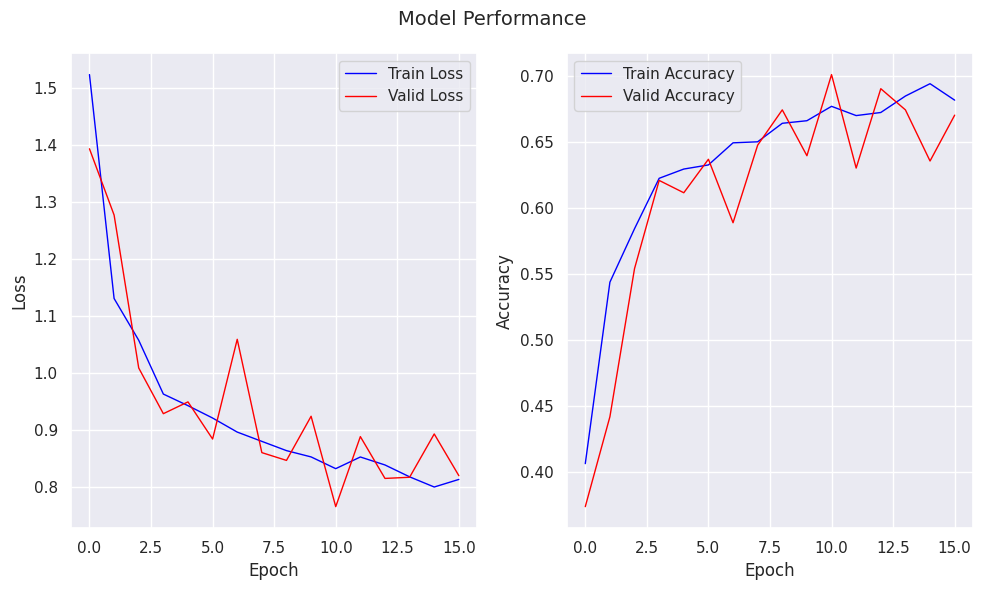

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/ModelDiffConv')
np.save('/content/gdrive/MyDrive/Models_DL_project/ModelDiffConv_history.npy', history.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/ModelDiffConv_history.npy'
modelDiffConv_history = np.load(path_history, allow_pickle=True).item()

# upload model
modelDiffConv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/ModelDiffConv")


In [ ]:
# test accuracy
loss, acc = modelDiffConv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 181s 16s/step - loss: 0.8649 - accuracy: 0.6420
Test loss: 0.8649032711982727
Test Accuracy 0.6420454382896423


With this more complex architecture we still got the same accuracy rate as in models we provide earlier, or even lower.

Therefore our consideration on this stage such that this kind of data has a lot of different specific features and for the customs models it's deficult to catch this features more precisely.

## Models with segmented data

To solve a problem mentioned before we try to model data after feature extraction, that in our case data segmentation. In more detail, we decided to remove the background in the images and leave only the flowers. For this we chose a simple **segmentation algorithm**: **threshold** (code for this transformation you can find in another notebook 'image_segmentation.ipynb')


In this topic we use Model 0 because it provides higher accuracy

### Data loader

In [ ]:
copyfile('gdrive/My Drive/DL_project/flower_black.zip', 'flower_black.zip')
zip = zipfile.ZipFile('flower_black.zip')
zip.extractall()
zip.close()

In [ ]:
base_path2 = '/content/flower_black'

In [ ]:
train_ds2 = keras.preprocessing.image_dataset_from_directory(base_path2,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


In [ ]:
val_dataset2 = keras.preprocessing.image_dataset_from_directory(base_path2,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [ ]:
val_batches2 = tf.data.experimental.cardinality(val_dataset2)
test_ds2 = val_dataset2.take((val_batches2) // 3)
val_ds2 = val_dataset2.skip((val_batches2) // 3)

In [ ]:
print("Number of batches in train dataset:", len(train_ds2))
print("Number of batches in validation dataset:", len(val_ds2))
print("Number of batches in test dataset:", len(test_ds2))


Number of batches in train dataset: 81
Number of batches in validation dataset: 24
Number of batches in test dataset: 11


### Visualization

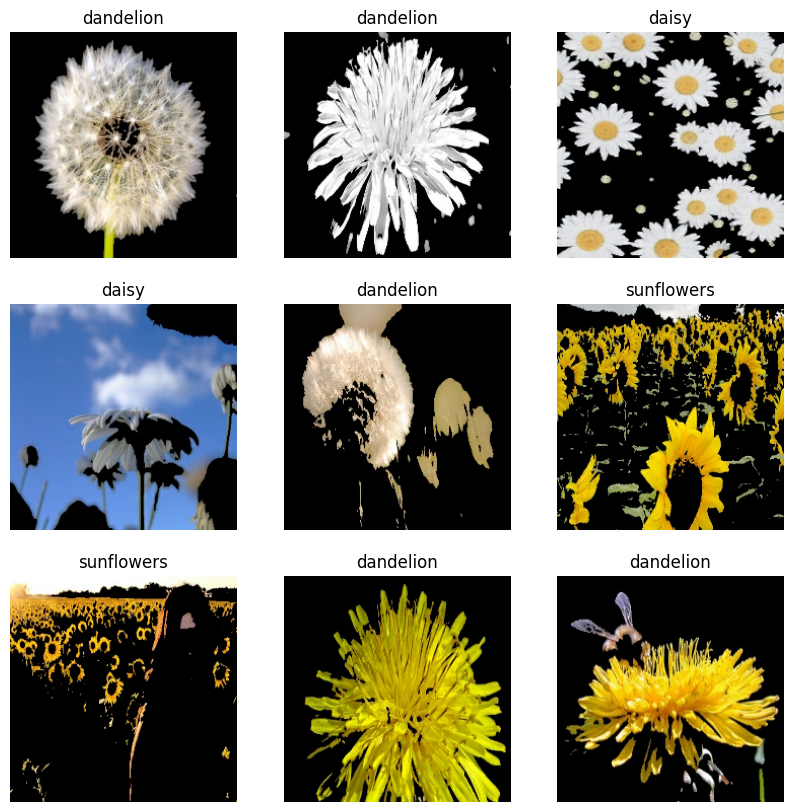

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = np.argmax(labels[i])  # convert one-hot label to class index
    plt.title(class_names[class_index])
    plt.axis("off")


### Model 0



In [ ]:
inputs = keras.Input((224,224,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        1849

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
%%time
history = net.fit(train_ds2,
          epochs=50,
          validation_data=val_ds2,
          callbacks=[callback]);

Epoch 1/50
81/81 [==============================] - 14s 120ms/step - loss: 1.4921 - accuracy: 0.4827 - val_loss: 2.4531 - val_accuracy: 0.3632
Epoch 2/50
81/81 [==============================] - 11s 131ms/step - loss: 1.1549 - accuracy: 0.6185 - val_loss: 1.1389 - val_accuracy: 0.6208
Epoch 3/50
81/81 [==============================] - 9s 110ms/step - loss: 1.0540 - accuracy: 0.6590 - val_loss: 1.0392 - val_accuracy: 0.6622
Epoch 4/50
81/81 [==============================] - 11s 122ms/step - loss: 0.9106 - accuracy: 0.7334 - val_loss: 1.3270 - val_accuracy: 0.5728
Epoch 5/50
81/81 [==============================] - 11s 124ms/step - loss: 0.8741 - accuracy: 0.7415 - val_loss: 1.0500 - val_accuracy: 0.6542
Epoch 6/50
81/81 [==============================] - 11s 127ms/step - loss: 0.7480 - accuracy: 0.7972 - val_loss: 1.1762 - val_accuracy: 0.6435
Epoch 7/50
81/81 [==============================] - 9s 109ms/step - loss: 0.7178 - accuracy: 0.8081 - val_loss: 0.9825 - val_accuracy: 0.6996
E

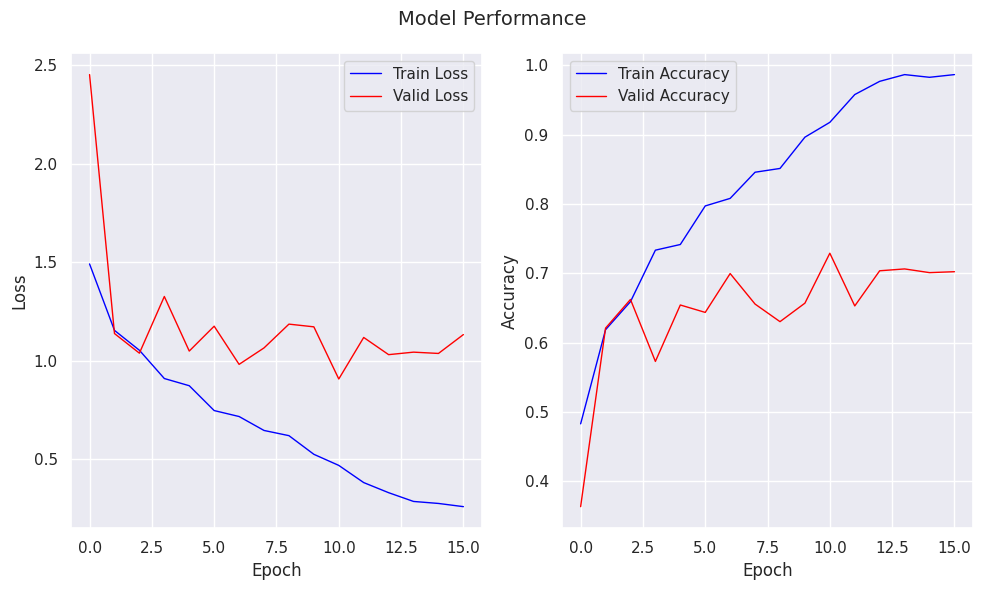

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/ModelBlackConv')
np.save('/content/gdrive/MyDrive/Models_DL_project/ModelBlackConv_history.npy', history.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/ModelBlackConv_history.npy'
modelBlackConv_history = np.load(path_history, allow_pickle=True).item()

# upload model
modelBlackConv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/ModelBlackConv")


In [ ]:
# test accuracy
loss, acc = modelBlackConv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 12s 968ms/step - loss: 1.0628 - accuracy: 0.6960
Test loss: 1.0627652406692505
Test Accuracy 0.6960227489471436


The same model with segmented data gives worse result in classification with accuracy 69%, at the seme time with original data we have 77% accuracy

### Model 0 + data augmentation

In [ ]:
inputs = keras.Input((224,224,3))

x = inputs
x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net = keras.Model(inputs, outputs)

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
%%time
history = net.fit(train_ds2,
          epochs=50,
          validation_data=val_ds2,
          callbacks=[callback]);

Epoch 1/50
81/81 [==============================] - 15s 95ms/step - loss: 1.3582 - accuracy: 0.5714 - val_loss: 1.6583 - val_accuracy: 0.4940
Epoch 2/50
81/81 [==============================] - 10s 114ms/step - loss: 1.1328 - accuracy: 0.6349 - val_loss: 1.3720 - val_accuracy: 0.5047
Epoch 3/50
81/81 [==============================] - 11s 133ms/step - loss: 1.0722 - accuracy: 0.6649 - val_loss: 1.2060 - val_accuracy: 0.5874
Epoch 4/50
81/81 [==============================] - 8s 92ms/step - loss: 1.0161 - accuracy: 0.6874 - val_loss: 1.2260 - val_accuracy: 0.5768
Epoch 5/50
81/81 [==============================] - 8s 94ms/step - loss: 0.9965 - accuracy: 0.6933 - val_loss: 1.0633 - val_accuracy: 0.6676
Epoch 6/50
81/81 [==============================] - 10s 114ms/step - loss: 0.9697 - accuracy: 0.7131 - val_loss: 0.9831 - val_accuracy: 0.6769
Epoch 7/50
81/81 [==============================] - 9s 107ms/step - loss: 0.9290 - accuracy: 0.7147 - val_loss: 1.0569 - val_accuracy: 0.6462
Epoch

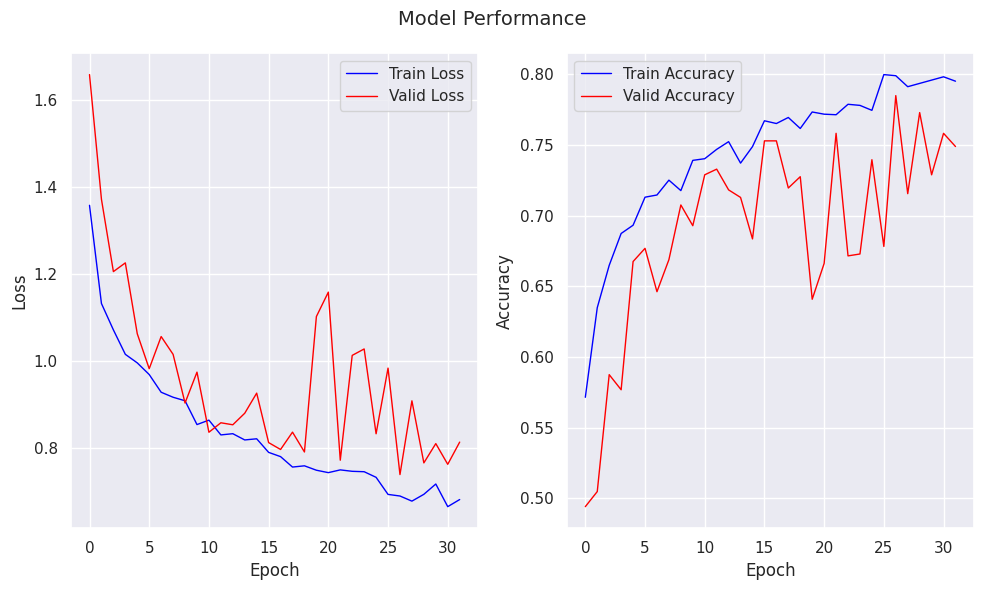

In [ ]:
plot_history(history.history)

In [ ]:
# save model and history
net.save('/content/gdrive/MyDrive/Models_DL_project/ModelBlackAugmConv')
np.save('/content/gdrive/MyDrive/Models_DL_project/ModelBlackAugmConv_history.npy', history.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/ModelBlackAugmConv_history.npy'
modelBlackAugmConv_history = np.load(path_history, allow_pickle=True).item()

# upload model
modelBlackAugmConv = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/ModelBlackAugmConv")


In [ ]:
# test accuracy
loss, acc = modelBlackAugmConv.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 10s 917ms/step - loss: 0.8661 - accuracy: 0.7528
Test loss: 0.8661195635795593
Test Accuracy 0.7528409361839294


Using Model 0 and data augmentation for the segmented data we obtain 75% accuracy and accuracy on original data is 73%

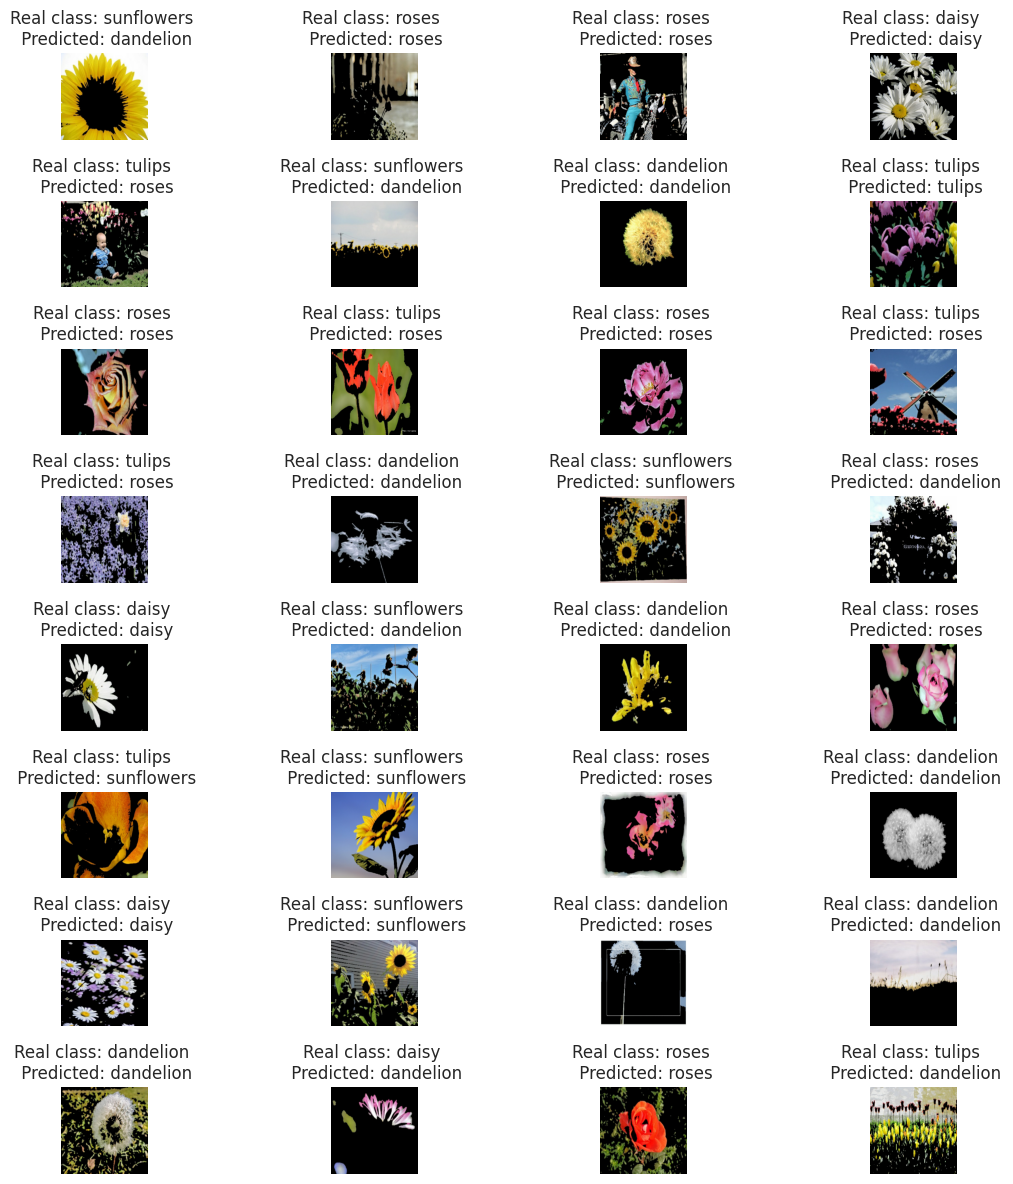

In [ ]:
plot_predicted(modelBlackAugmConv, test_ds2)

## Conclusion

In this notebook, we have developed various convolutional neural network architectures to classify a selected dataset of flower images. The best architecture with our proposed is the Model 0 + data augmentation, that has accuracy for the original data 73,5% and accuracy for the segmented dataset 75%.

Data segmentation was also used to improve the performance of the model. On this example, we can say that we did not get a significant improvement in classification accuracy. In future we can propose to choose another segmentation method for more accurate feature selection.

In the next notebook we use pre-trained models and fine tuning for the image classification.

References:
1. Image augmentation ( https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/ )
2. Keras documentation ( https://keras.io/api/ )
3. Techniques to prevent overfitting ( https://towardsdatascience.com/8-simple-techniques-to-prevent-overfitting-4d443da2ef7d )
4. Flower Categorization using Deep Convolutional Neural Networks ( https://arxiv.org/abs/1708.03763 )
5. Image Segmentation Algorithms Overview ( https://arxiv.org/ftp/arxiv/papers/1707/1707.02051.pdf )



